# Implementando uma MLP básica com Grid Search para escolher melhor os parâmetros

## 1. Importando as bibliotecas necessárias

### 1.1 Bibliotecas gerais

In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns # a biblioteca 'seaborn' contém vários estilos para os gráficos do 'matpĺotlib'

# agora, melhoramos a qualidade de saida e de visualizacao da imagem 
# alem de mudar a fonte padrao para uma do latex
sns.set_style("ticks")
plt.rcParams['savefig.dpi'] = 200
plt.rcParams["figure.dpi"] = 100

plt.rcParams.update({
    "text.usetex": True,
    "font.family": "serif",
    "font.serif": ["Palatino"],
})
plt.style.use('dark_background')

### 1.2 Bibliotecas para MLP

In [2]:
import tensorflow as tf
physical_devices = tf.config.list_physical_devices('GPU') 
tf.config.experimental.set_memory_growth(physical_devices[0], True)

from tensorflow import keras

In [3]:
from sklearn.model_selection import GridSearchCV
from sklearn.model_selection import train_test_split

from tensorboard.plugins.hparams import api as hp

In [4]:
from tensorflow.keras.wrappers.scikit_learn import KerasRegressor

### 1.3 Bibliotecas dos sistemas caóticos

In [5]:
import sys 
sys.path.insert(0, '../../../../scripts')

import timeseries as times
import lorenzsystem as lsys

## 2. Gerando a série temporal do sistema de Lorenz

Os valores para os parâmetros das equações serão os "básicos" apresentados no *paper* original.

In [6]:
t_inicial = 0
t_final = 100
dt = 0.001

In [7]:
estado_inicial = np.array([0.1, 0, 0])

In [8]:
sis_lorenz = lsys.SistemaLorenz(estado_inicial, dt=dt)

In [9]:
solucoes, instantes_temporais = sis_lorenz.calcular(t_inicial = t_inicial, t_final = t_final)

In [10]:
x = solucoes[:, 0]
y = solucoes[:, 1]
z = solucoes[:, 2]

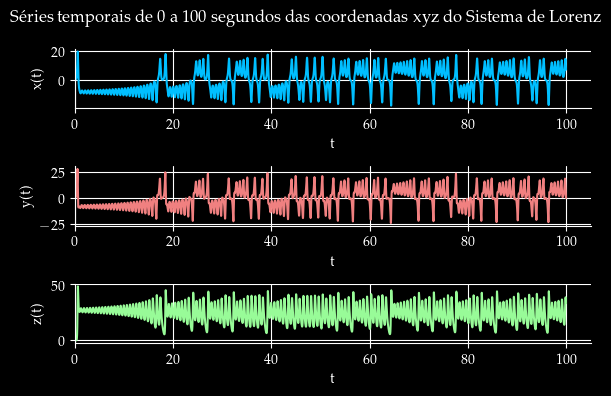

In [11]:
fig, ax = plt.subplots(3)
fig.suptitle("Séries temporais de 0 a 100 segundos das coordenadas xyz do Sistema de Lorenz")
ax[0].plot(instantes_temporais, x, color='DeepSkyBlue')

ax[0].set_ylabel('x(t)')
ax[0].set_xlabel('t')
ax[0].set_xlim(0,)
    
ax[0].grid(True)

ax[1].plot(instantes_temporais, y, color='LightCoral')
ax[1].set_ylabel('y(t)')
ax[1].set_xlabel('t')
ax[1].set_xlim(0,)
ax[1].grid(True)

ax[2].plot(instantes_temporais, z, color='PaleGreen')
ax[2].set_ylabel('z(t)')
ax[2].set_xlabel('t')
ax[2].set_xlim(0,)
ax[2].grid(True)

fig.tight_layout()
sns.despine()
plt.show()

### 2.1 Dividindo em um conjunto de treinamento e de teste, para K = 4 e L = 3

In [12]:
K = 4
L = 3
tam_teste = 0.1

In [13]:
serie_temporal = times.SerieTemporal(x, K=K, L=L)

In [14]:
serie_temporal.criar_matrizes()

In [15]:
X_treino, X_teste, y_treino, y_teste = serie_temporal.dividir_treino_teste(tam_teste)

## 3. Definindo o modelo para a MLP

### 3.1 Definindo parâmetros que não serão definidos pelo Grid Search

In [28]:
param_grid = dict(batch_size=[1, 2, 4, 8, 16, 24, 32, 48, 64, 128], 
                  batch_normalization=['ON', 'OFF'], 
                  activation=['selu', 'relu', 'elu', 'sigmoid', 'tanh', 'logitic'], 
                  init_mode = ['lecun_uniform', 'lecun_normal', 'glorot_normal', 'glorot_uniform', 'he_normal', 'he_uniform'],
                  learnig_rate = [0.001, 0.003, 0.005, 0.008, 0.01])

In [29]:
loss = "mean_squared_error"
optimizer = keras.optimizers.Nadam()

In [30]:
early_stopping_cv = tf.keras.callbacks.EarlyStopping(patience=10, restore_best_weights=True, monitor='loss')

### 3.2 Definindo as primeiras métricas a serem avaliadas pelo Grid Search

Primeiro, avaliaremos o impacto do *batch size*, da função de ativação e da inicialização dos neurônios, e a taxa de aprendizado. O número de épocas será determinado quando formos treinar a rede, através do *early stopping*.

In [31]:
param_grid_1 = dict(batch_size=[2, 4, 8, 16, 32], 
                  batch_normalization=['ON', 'OFF'])

### 3.2 Definindo função para criar a MLP

In [32]:
def criar_modelo(batch_normalization='ON', learning_rate=0.001, activation='selu', init_mode='lecun_normal', n_neurons=30):
    
    optimizer_gs = optimizer
    optimizer_gs.learning_rate.assign(learning_rate)
    
    model = keras.Sequential()
    model.add(keras.layers.Dense(K, input_dim=K, name="camada_de_entrada", activation = 'linear'))
    if (batch_normalization == 'ON'):
        model.add(keras.layers.BatchNormalization(name="camada_de_batch_normalization"))
    model.add(keras.layers.Dense(n_neurons, input_dim=K, activation=activation, kernel_initializer=init_mode, name="camada_intermediaria"))
    model.add(keras.layers.Dense(1, activation='linear', name="camada_de_saida"))
    
    model.compile(
        optimizer = optimizer_gs,
        loss = loss)
    
    model.build()
    return model

In [33]:
model_cv_1 = KerasRegressor(build_fn=criar_modelo, epochs=100, verbose=0)

In [34]:
grid = GridSearchCV(estimator=model_cv_1, param_grid=param_grid_1, n_jobs=6, cv=4)

In [35]:
grid_result = grid.fit(X_treino, y_treino, callbacks=early_stopping_cv)

KeyboardInterrupt: 

In [36]:
print("Best: %f using %s" % (grid_result.best_score_, grid_result.best_params_))

NameError: name 'grid_result' is not defined

### Treino com o melhor modelo

In [25]:
model = criar_modelo(batch_normalization='ON')

In [26]:
model.summary()

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
camada_de_entrada (Dense)    (None, 4)                 20        
_________________________________________________________________
camada_de_batch_normalizatio (None, 4)                 16        
_________________________________________________________________
camada_intermediaria (Dense) (None, 30)                150       
_________________________________________________________________
camada_de_saida (Dense)      (None, 1)                 31        
Total params: 217
Trainable params: 209
Non-trainable params: 8
_________________________________________________________________


In [27]:
X_treino, X_val, y_treino, y_val = train_test_split(X_treino, y_treino, test_size=0.1)

In [28]:
early_stopping = tf.keras.callbacks.EarlyStopping(patience=10, restore_best_weights=True, monitor='val_loss')

In [29]:
batch_size = 32

In [30]:
history = model.fit(X_treino, y_treino, epochs=100,
                            callbacks=early_stopping, validation_data=(X_val, y_val),
                            batch_size=batch_size)
treinamento = pd.DataFrame(history.history)

Epoch 1/100
2532/2532 [==============================] - 5s 2ms/step - loss: 7.5056 - root_mean_squared_error: 2.5764 - val_loss: 0.6871 - val_root_mean_squared_error: 0.8289
Epoch 2/100
2532/2532 [==============================] - 4s 2ms/step - loss: 2.6277 - root_mean_squared_error: 1.6205 - val_loss: 1.2196 - val_root_mean_squared_error: 1.1044
Epoch 3/100
2532/2532 [==============================] - 4s 2ms/step - loss: 2.6006 - root_mean_squared_error: 1.6123 - val_loss: 1.8453 - val_root_mean_squared_error: 1.3584
Epoch 4/100
2532/2532 [==============================] - 4s 2ms/step - loss: 2.5212 - root_mean_squared_error: 1.5868 - val_loss: 0.1286 - val_root_mean_squared_error: 0.3586
Epoch 5/100
2532/2532 [==============================] - 4s 2ms/step - loss: 2.6861 - root_mean_squared_error: 1.6380 - val_loss: 0.3984 - val_root_mean_squared_error: 0.6312
Epoch 6/100
2532/2532 [==============================] - 5s 2ms/step - loss: 2.5243 - root_mean_squared_error: 1.5882 - val_l

## Teste com o melhor modelo

In [37]:
y_pred = model.predict(X_teste)

ValueError: in user code:

    /usr/local/lib/python3.8/dist-packages/tensorflow/python/keras/engine/training.py:1478 predict_function  *
        return step_function(self, iterator)
    /usr/local/lib/python3.8/dist-packages/tensorflow/python/keras/engine/training.py:1468 step_function  **
        outputs = model.distribute_strategy.run(run_step, args=(data,))
    /usr/local/lib/python3.8/dist-packages/tensorflow/python/distribute/distribute_lib.py:1259 run
        return self._extended.call_for_each_replica(fn, args=args, kwargs=kwargs)
    /usr/local/lib/python3.8/dist-packages/tensorflow/python/distribute/distribute_lib.py:2730 call_for_each_replica
        return self._call_for_each_replica(fn, args, kwargs)
    /usr/local/lib/python3.8/dist-packages/tensorflow/python/distribute/distribute_lib.py:3417 _call_for_each_replica
        return fn(*args, **kwargs)
    /usr/local/lib/python3.8/dist-packages/tensorflow/python/keras/engine/training.py:1461 run_step  **
        outputs = model.predict_step(data)
    /usr/local/lib/python3.8/dist-packages/tensorflow/python/keras/engine/training.py:1434 predict_step
        return self(x, training=False)
    /usr/local/lib/python3.8/dist-packages/tensorflow/python/keras/engine/base_layer.py:998 __call__
        input_spec.assert_input_compatibility(self.input_spec, inputs, self.name)
    /usr/local/lib/python3.8/dist-packages/tensorflow/python/keras/engine/input_spec.py:255 assert_input_compatibility
        raise ValueError(

    ValueError: Input 0 of layer sequential is incompatible with the layer: expected axis -1 of input shape to have value 4 but received input with shape (32, 1)


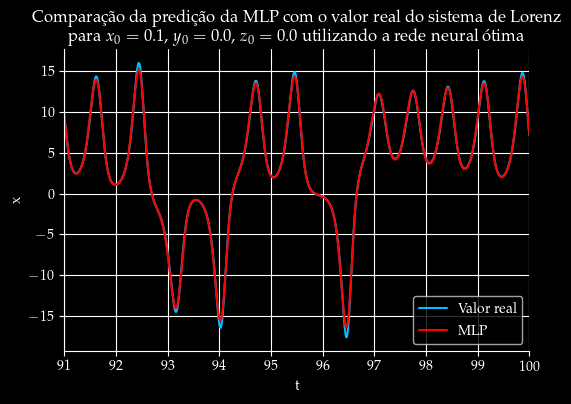

In [42]:
fig, ax = plt.subplots()
ax.plot(instantes_temporais[len(instantes_temporais)-int(len(instantes_temporais)*tam_teste):,], y_teste, color='DeepSkyBlue', label='Valor real')
ax.plot(instantes_temporais[len(instantes_temporais)-int(len(instantes_temporais)*tam_teste):,], y_pred, color='Red', label='MLP')

ax.set_title("Comparação da predição da MLP com o valor real do sistema de Lorenz \npara $x_{0} = $ " + str(estado_inicial[0]) + ", $y_{0} = $ " + str(estado_inicial[1]) + ", $z_{0} = $ " + str(estado_inicial[2]) + " utilizando a rede neural ótima")
ax.set_ylabel('x')
ax.set_xlabel('t')
ax.set_xlim(91, 100)
    
ax.grid(True)
sns.despine()
ax.legend()

plt.show()